# Sieci konwolucyjne

Zadanie dla Państwa na te ćwiczenia to implementacja funkcji konwolucji oraz max pooling dla obrazów.

In [7]:
# ploting
# Max Pooling Test
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
# imports
import torch

%matplotlib inline

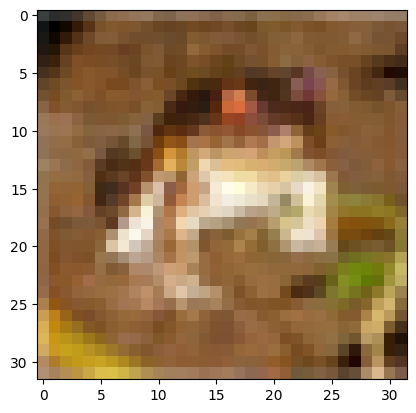

In [8]:
# data loading
cifar_sample = np.load("cifar_sample.npy")
# get a first random image
np_image = cifar_sample[0]
# this should plot a blurry frog
plt.imshow(np_image.transpose(1, 2, 0))

### Wzory na rozmiary
**Pytanie 1**: Jaki będzie rozmiar obrazka na wyjściu konwolucji/poolingu przy parametrach poniżej.  
**Uwaga**: zarówno we wzorach jak i w kodzie używana jest torchowa konwencja *channel first*.

Stride: $ \hspace{95px} S $  
Padding: $ \hspace{80px} P $  
Obrazek wejściowy: $ \hspace{12px} C_i \times H_i \times W_i$  
Filtry: $ \hspace{100px} K \times C_f \times F \times F $  

Gdzie: $C_i$ to liczba kanału obrazu wejściowego, $H_i, W_i$ to odpowiednio wysokość i szerokość obrazu wejściowego. $K$ to liczba filtrów, $C_f$ liczba kanałów w każdym filtrze, $F$ to zarówno wysokość jak i szerokość filtra (rozważamy tylko filtry kwadratowe).

Obrazek wyjściowy: $ \hspace{15px} C_o \times H_o \times W_o $  


$ \hspace{140px} C_o = \text{???} $  

$ \hspace{140px} H_o = \text{???} $  

$ \hspace{140px} W_o = \text{???} $  

**Pytanie 2**: Ile wag (floatów) ma taka warstwa konwolucyja?   


### Wizualna pomoc do konwolucji
[Źródło](http://cs231n.github.io/convolutional-networks/)

<img src="resources/cnn.gif"></img>

### Zadanie 1:  Konwolucja (5 pkt.)
Zadaniem jest zaimplementowanie funkcji konwolucji i poolingu dla obrazka 2D. Implementacja nie musi być optymalna pod względem złożoności czasowej (tzn. można/zaleca się używać pętli).

Warunkiem zaliczenia zadania jest przejście komórek testowych dla konwolucji i poolingu. W razie problemów polecam zacząć od poolingu, który jest podobny do konwolucji, ale mniej skomplikowany.

In [9]:
def convolution(image: torch.tensor,
                filters: torch.tensor,
                bias: torch.tensor,
                stride: int = 1,
                padding: int = 1):
    """
    :param image: torch.Tensor
        Input image of shape (C, H, W)
    :param filters: torch.Tensor
        Filters to use in convolution of shape (K, C, F, F)
    :param bias: torch.Tensor
        Bias vector of shape (K,)
    :param stride: int
        Stride to use in convolution
    :param padding: int
       Zero-padding to add on all sides of the image
    """
    # get image dimensions
    img_channels, img_height, img_width = image.shape
    n_filters, filter_channels, filter_size, filter_size = filters.shape
    # calculate the dimensions of the output image
    out_height = (img_height + 2 * padding - filter_size) // stride + 1
    out_width = (img_width + 2 * padding - filter_size) // stride + 1
    out_channels = n_filters

    # zero-padding входного изображения
    if padding > 0:
        padded_height = img_height + 2 * padding
        padded_width = img_width + 2 * padding
        padded_image = torch.zeros(
            (img_channels, padded_height, padded_width),
            dtype=image.dtype, device=image.device
        )
        padded_image[:, padding:padding+img_height, padding:padding+img_width] = image
    else:
        padded_image = image

    # Выходной тензор
    output = torch.zeros(
        (out_channels, out_height, out_width),
        dtype=image.dtype, device=image.device
    )

    # Основные циклы свёртки: (кол-во фильтров) x (пространственные координаты)
    for k in range(n_filters):
        for i in range(out_height):
            for j in range(out_width):
                # координаты вырезаемого «патча» из входа
                row_start = i * stride
                row_end = row_start + filter_size
                col_start = j * stride
                col_end = col_start + filter_size

                # Извлекаем соответствующий участок (patch)
                patch = padded_image[:, row_start:row_end, col_start:col_end]
                # (C_f, F, F)

                # Умножаем patch на веса k-го фильтра и суммируем все элементы
                output[k, i, j] = (patch * filters[k]).sum() + bias[k]

    return output

In [10]:
# Convolution Test

# cast the frog to tensor
image = torch.tensor(np_image)
# preapre parameters for testing
paddings = [0, 1, 2, 3]
strides = [1, 2, 3, 4]
filters = [
    (torch.randn((2, 3, 3, 3)), torch.randn((2))),
    (torch.randn((2, 3, 5, 5)), torch.randn((2))),
    (torch.randn((5, 3, 1, 1)), torch.randn((5))),
]

# test all combinations
for (filt, bias), stride, padding in product(filters, strides, paddings):
    # your convolution
    out = convolution(image, filt, bias, stride=stride, padding=padding)
    # PyTorch equivalent
    out_torch = torch.conv2d(
        input=image.unsqueeze(0), weight=filt, bias=bias, padding=padding, stride=stride
    )
    # asserts
    assert out_torch.squeeze().shape == out.shape
    assert torch.allclose(out, out_torch.squeeze(), atol=1e-5, rtol=1e-5)

### Zadanie 2. Max Pooling (2 pkt.)
Operacja *max pooling* jest analogiczna do zwykłej konwolucji, lecz zamiast operacji mnożenia z zadanym filtrem na każdym fragmencie wejścia wykonywana jest funkcja *max*.

In [11]:
def max_pooling(image: torch.tensor,
                kernel_size: int,
                stride: int = 1,
                padding: int = 1):
    """
    :param image: torch.Tensor
        Input image of shape (C, H, W)
    :param kernel_size: int
        Size of the square pooling kernel
    :param stride: int
        Stride to use in pooling
    :param padding: int
       Zero-padding to add on all sides of the image
    """
    # get image dimensions
    img_channels, img_height, img_width = image.shape
    # calculate the dimensions of the output image
    out_height = (img_height + 2 * padding - kernel_size) // stride + 1
    out_width = (img_width + 2 * padding - kernel_size) // stride + 1
    out_channels = img_channels  # Пулинг не меняет число каналов

    # Zero-padding
    if padding > 0:
        padded_height = img_height + 2 * padding
        padded_width = img_width + 2 * padding
        padded_image = torch.zeros(
            (img_channels, padded_height, padded_width),
            dtype=image.dtype, device=image.device
        )
        padded_image[:, padding:padding+img_height, padding:padding+img_width] = image
    else:
        padded_image = image

    # Выход
    output = torch.zeros(
        (out_channels, out_height, out_width),
        dtype=image.dtype, device=image.device
    )

    # Основные циклы
    for c in range(img_channels):
        for i in range(out_height):
            for j in range(out_width):
                row_start = i * stride
                row_end = row_start + kernel_size
                col_start = j * stride
                col_end = col_start + kernel_size

                patch = padded_image[c, row_start:row_end, col_start:col_end]
                output[c, i, j] = patch.max()

    return output

In [12]:
# cast the frog to tensor
image = torch.tensor(np_image)
# preapre parameters for testing
kernel_sizes = [2, 3, 4]
paddings = [0, 1]
strides = [1, 2, 3, 4]

# test all combinations
for kernel_size, stride, padding in product(kernel_sizes, strides, paddings):
    # your pooling
    out = max_pooling(image, kernel_size=kernel_size, stride=stride, padding=padding)
    # PyTorch equivalent
    out_torch = torch.nn.functional.max_pool2d(
        input=image.unsqueeze(0), kernel_size=kernel_size, padding=padding, stride=stride
    )
    # asserts
    assert out_torch.squeeze().shape == out.shape
    assert torch.allclose(out, out_torch.squeeze(), atol=1e-5, rtol=1e-5)

# Trenowanie sieci kowolucyjnych

**Uwaga:** Poniższa część notebooka jest stworzona z myślą o uruchamianiu go w [Colaboratory](https://colab.research.google.com/) (link do przeglądania repozytoriów w colabie: [link](https://colab.research.google.com/github/)), oznacza to, że przygotowane zadania zakładają uczenie modelu z użyciem GPU. Na zajęciach zostanie krótko omówione używanie Colaboratory. Na własną odpowiedzialność można używać własnego komputera do rozwiązania pracy domowej.

In [13]:
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import (RandomVerticalFlip, ToTensor)
import torch.nn.functional as F
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### CIFAR10
[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) to dataset zawierający 60 tysięcy kolorowych obrazków rozmiaru 32 $\times$ 32 pikseli należących do 10 różnych klas. Poniżej przykładowe wizualizacje.

100%|██████████| 170M/170M [00:05<00:00, 29.8MB/s]


Extracting ./cifar-10-python.tar.gz to .
CIFAR10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


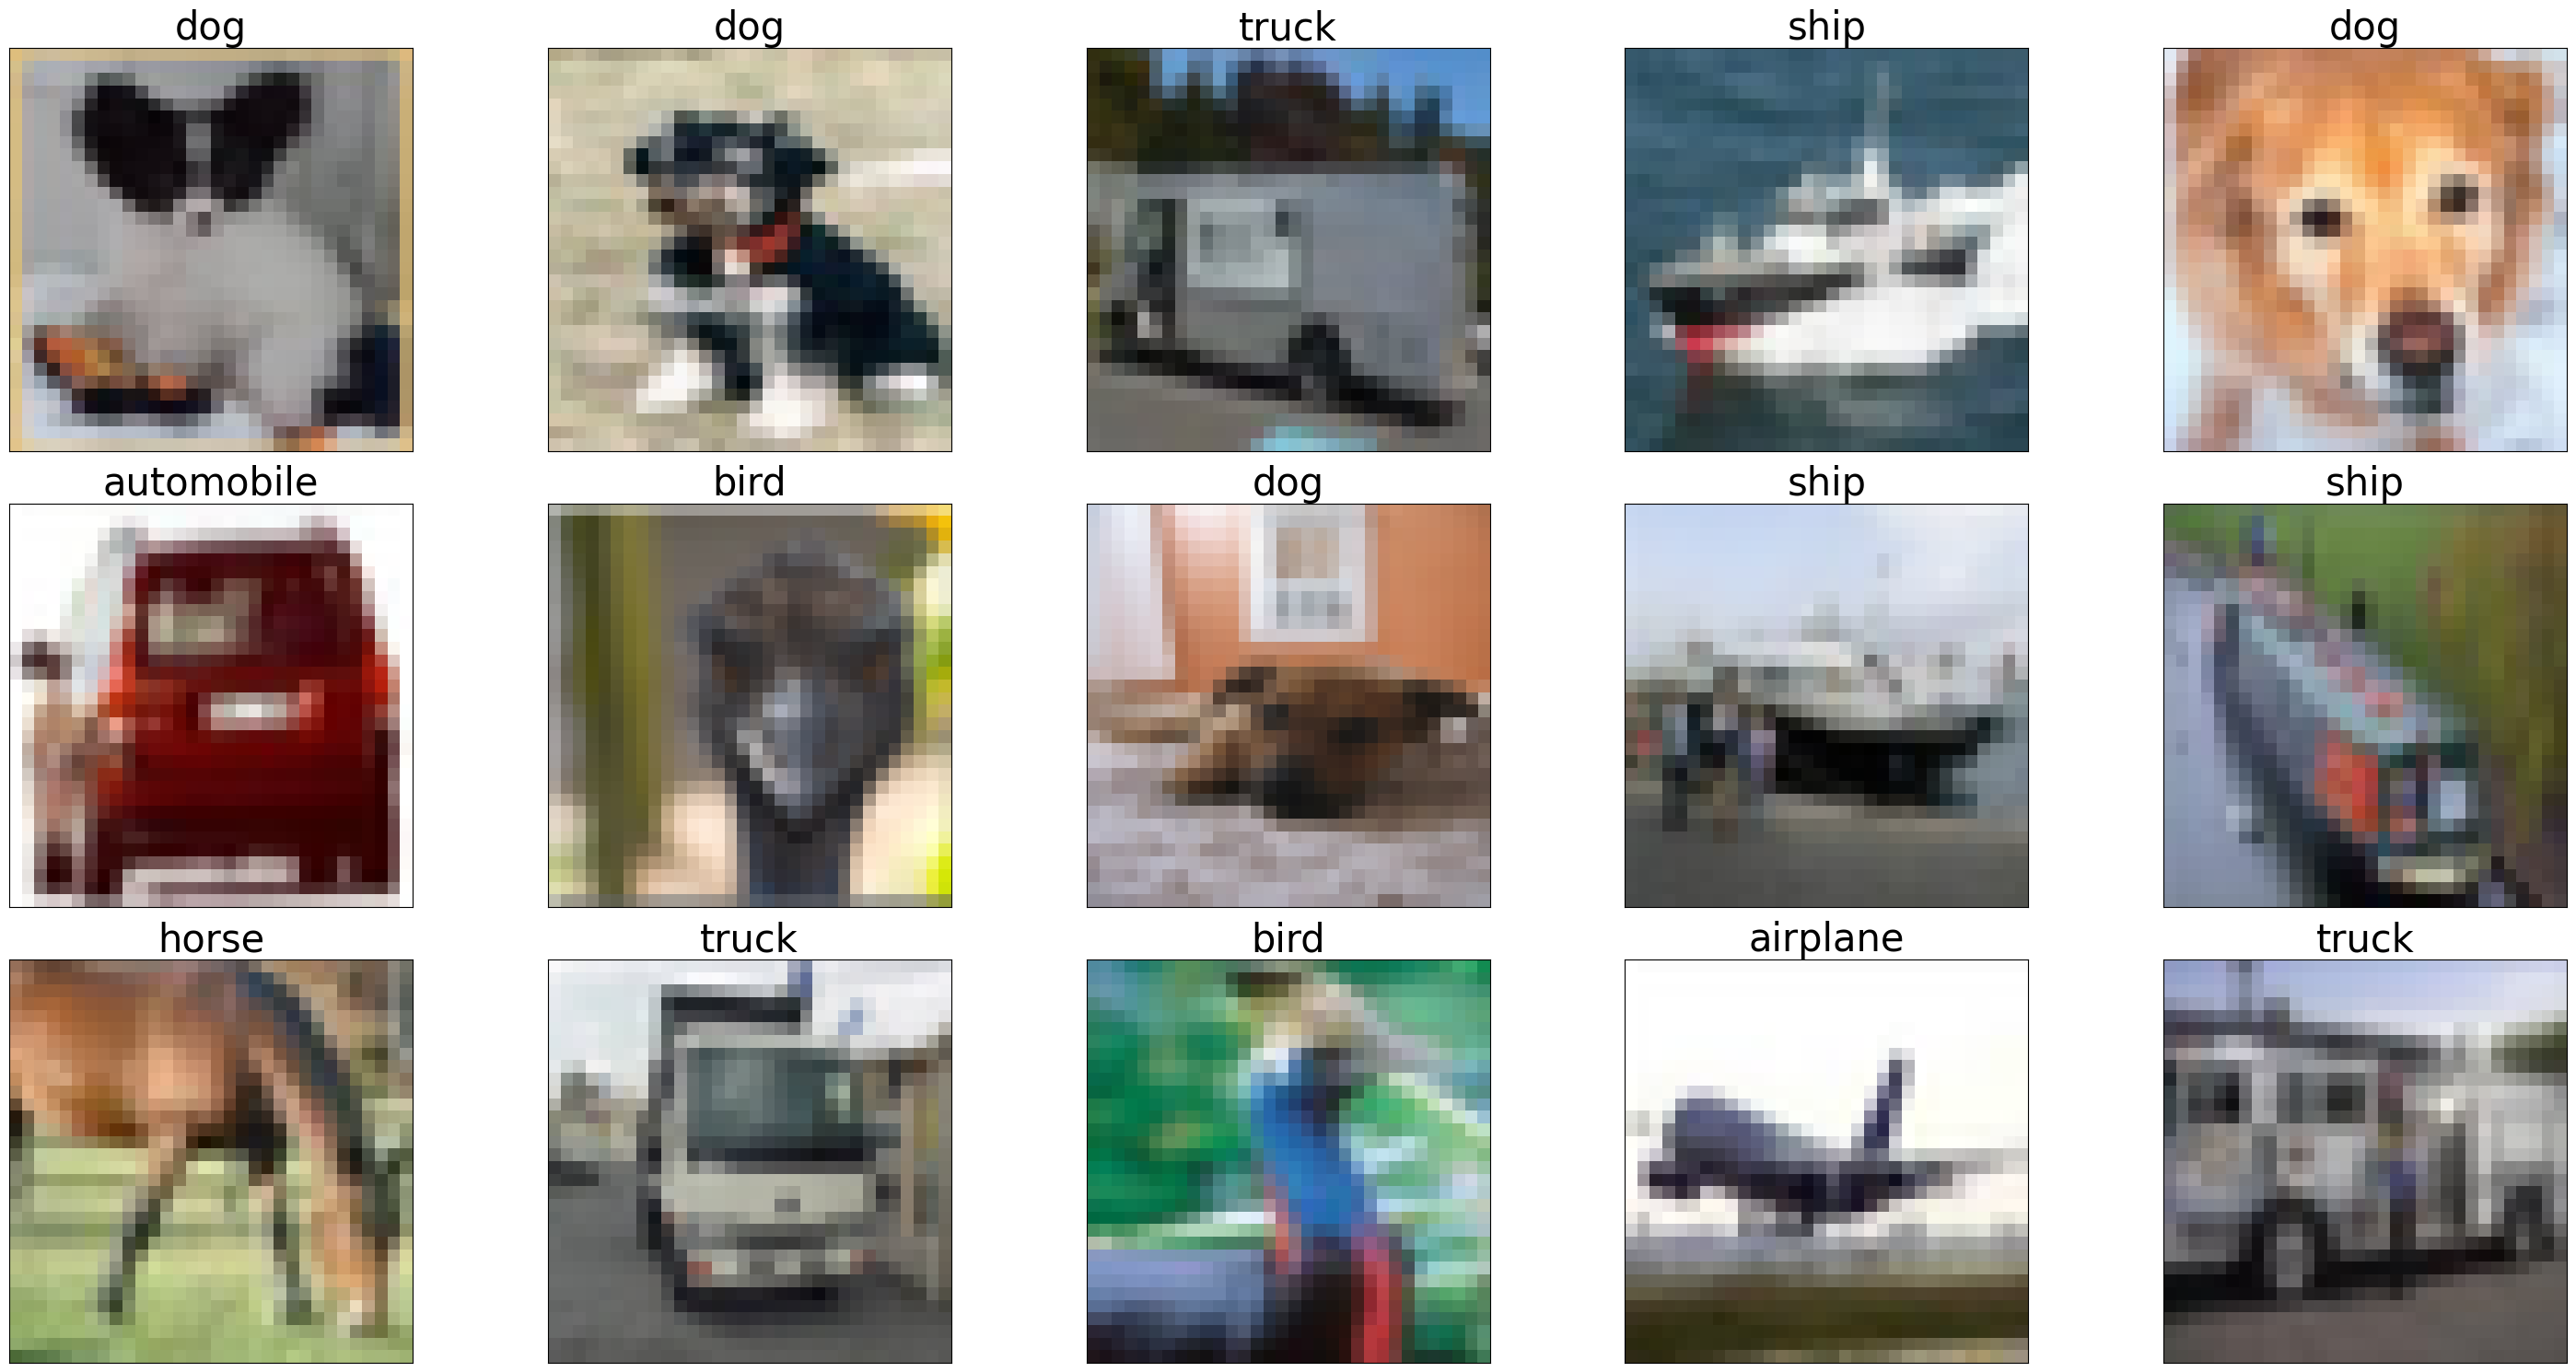

In [14]:
dataset = CIFAR10(root=".", train=True, transform=ToTensor(), download=True)
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# get a single batch
for x, y in loader:
    break

# prepare visualisations
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30, 15))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ind = 5 * i + j
        ax.imshow(np.transpose(x[ind], (1, 2, 0)))
        ax.set_title(f"{dataset.classes[y[ind]]}", fontdict={"size": 30})
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()

print(f"CIFAR10 classes: {dataset.classes}")

### Zadanie 3. Sieć Konwolucyjna na CIFAR10 (4 pkt.)

Zadaniem jest zaimplementowanie "od zera" sieci konwolucyjnej do klasyfikacji wieloklasowej na zbiorze CIFAR10. Należy zaimplementować zarówno model jak i pętle uczenia oraz ewaluacji. Twój kod powinien raportować *loss* w trakcie trenowania, testowania oraz *accuracy* na zbiorze testowym (opcjonalnie również na treningowym). Na koniec *accuracy* powinno osiągnąć wynik powyżej 75% na zbiorze testowym. Można korzystać z dowolnych mechanizmów dostępnych w PyTorchu.

Porady do zadania:

* Zwiększenie treningowego *batch size* może przyspieszyć uczenie, ale należy pamiętać, że, tak jak każdy hiperparametr, *batch_size* ma wpływ na proces uczenia.
* Przy dobieraniu architektury bądź hiperparametrów nie testować dłużej niż kilka epok (około 5), tak aby mieć szybki feedback. Dopiero po dobraniu powyższych rzeczy puścić dłuższe uczenie. Warto przy okazji wizualizować krzywe uczenia (funkcji kosztu) aby zwrócić uwagę na to kiedy koszt zaczyna się "wypłaszczać" i czy model przypadkowo nie overfituje (patrząc na wartości kosztu na zbiorze testowym)
* Dodatkowe (nadobowiązkowe) rzeczy do poprawienia wyniku: LR Schedule, Early Stopping.

In [15]:
# tutaj zdefiniuj swój model, nie zapomnij o dziedziczeniu z torch.nn.Module
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # reduce H,W by a factor of 2 each time
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # B, 32, 32, 32
        x = self.pool(x)           # B, 32, 16, 16
        x = F.relu(self.conv2(x))  # B, 64, 16, 16
        x = self.pool(x)           # B, 64, 8, 8
        x = F.relu(self.conv3(x))  # B, 128, 8, 8
        x = self.pool(x)           # B, 128, 4, 4
        x = x.view(x.size(0), -1)  # B, 128*4*4
        x = F.relu(self.fc1(x))    # B, 256
        x = self.fc2(x)            # B, 10
        return x

In [16]:
# tutaj uzupełnij ładowanie danych treningowych i testowych

train_dataset = CIFAR10(root='.',
                        train=True,
                        download=True,
                        transform=ToTensor())

test_dataset = CIFAR10(root='.',
                       train=False,
                       download=True,
                       transform=ToTensor())


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [19]:
# tutaj zaimplementuj pętle uczenia ze wszystkimi potrzebnymi hiperparametrami
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(dim=1)
        total_correct += predicted.eq(labels).sum().item()
        total_samples += inputs.size(0)

    train_loss = total_loss / total_samples
    train_acc = total_correct / total_samples

    # ewaluacja
    model.eval()
    test_loss_val = 0.0
    test_correct = 0
    test_samples = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss_val += loss.item() * inputs.size(0)
            _, predicted = outputs.max(dim=1)
            test_correct += predicted.eq(labels).sum().item()
            test_samples += inputs.size(0)

    test_loss = test_loss_val / test_samples
    test_acc = test_correct / test_samples

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {100*train_acc:.2f}% || "
          f"Test Loss: {test_loss:.4f} | Test Acc: {100*test_acc:.2f}%")


Epoch [1/20] Train Loss: 1.5920 | Train Acc: 41.78% || Test Loss: 1.3082 | Test Acc: 51.77%
Epoch [2/20] Train Loss: 1.2083 | Train Acc: 56.84% || Test Loss: 1.1419 | Test Acc: 59.28%
Epoch [3/20] Train Loss: 1.0111 | Train Acc: 64.31% || Test Loss: 0.9775 | Test Acc: 65.89%
Epoch [4/20] Train Loss: 0.8762 | Train Acc: 69.18% || Test Loss: 0.8808 | Test Acc: 69.39%
Epoch [5/20] Train Loss: 0.7807 | Train Acc: 72.70% || Test Loss: 0.8476 | Test Acc: 70.95%
Epoch [6/20] Train Loss: 0.6981 | Train Acc: 75.68% || Test Loss: 0.8162 | Test Acc: 72.23%
Epoch [7/20] Train Loss: 0.6358 | Train Acc: 77.88% || Test Loss: 0.8336 | Test Acc: 71.21%
Epoch [8/20] Train Loss: 0.5628 | Train Acc: 80.41% || Test Loss: 0.7664 | Test Acc: 74.04%
Epoch [9/20] Train Loss: 0.5030 | Train Acc: 82.32% || Test Loss: 0.8006 | Test Acc: 73.24%
Epoch [10/20] Train Loss: 0.4474 | Train Acc: 84.26% || Test Loss: 0.7911 | Test Acc: 73.79%
Epoch [11/20] Train Loss: 0.3923 | Train Acc: 86.24% || Test Loss: 0.8055 | Tes

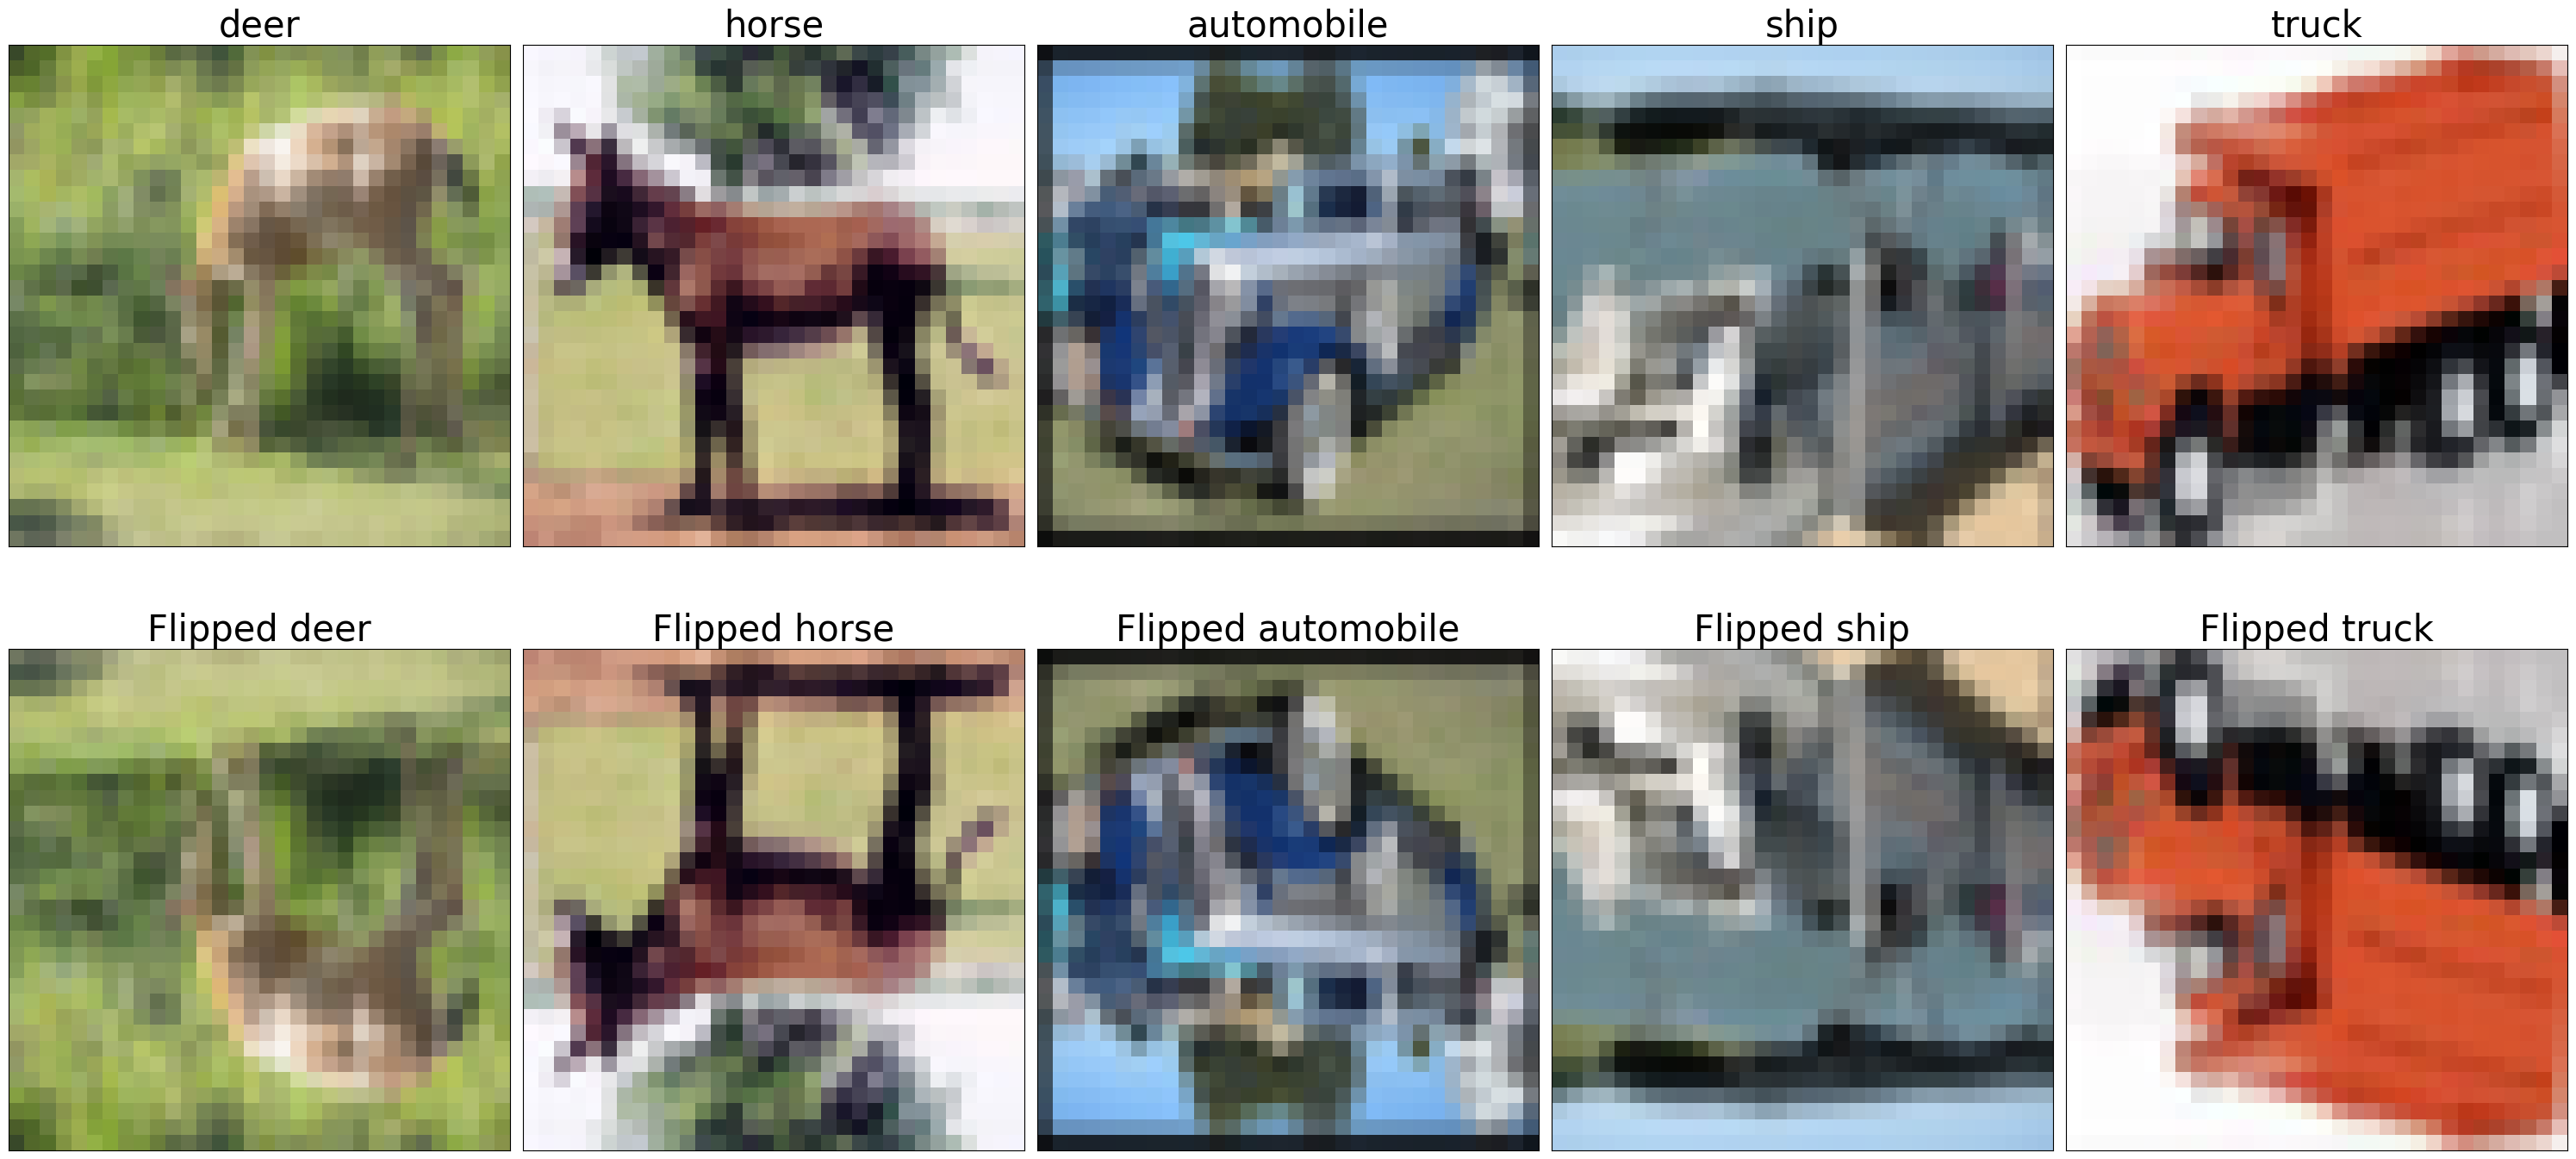

In [20]:
# load test set
dataset = CIFAR10(root=".", train=True, transform=ToTensor())
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# prepare a random flip
flip = RandomVerticalFlip(p=1)

# load some data
for x, y in loader:
    break


# visualise the flipping
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 15))

for img, label, ax in zip(x, y, axes[0]):
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title(f"{dataset.classes[label]}", fontdict={"size": 30})
    ax.set_xticks([])
    ax.set_yticks([])

for img, label, ax in zip(x, y, axes[1]):
    ax.imshow(np.transpose(flip(img), (1, 2, 0)))
    ax.set_title(f"Flipped {dataset.classes[label]}", fontdict={"size": 30})
    ax.set_xticks([])
    ax.set_yticks([])


fig.tight_layout()

### Zadanie 4. Augmentacja danych (1 pkt.)

Używając funkcjonalności dostępnych w [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) dodaj augmentacje danych do datasetu treningowego, zobacz o ile poprawia to wynik twojego modelu z poprzedniego zadania. W razie wątpliwości najlepiej przeszukać internet w poszukiwaniu typowych augmentacji dla CIFAR10.

In [26]:
# tutaj dodaj wybrane augumentcje danych treningowych i załaduj testowe
from torchvision.transforms import Compose, RandomCrop, RandomHorizontalFlip

aug_transform = Compose([
    RandomCrop(32, padding=4),
    RandomHorizontalFlip(),
    ToTensor(),
])
train_dataset = CIFAR10(root='.',
                        train=True,
                        download=True,
                        transform=aug_transform)

test_dataset = CIFAR10(root='.',
                       train=False,
                       download=True,
                       transform=aug_transform)

#====

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=4)

model = MyCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(dim=1)
        total_correct += predicted.eq(labels).sum().item()
        total_samples += inputs.size(0)

    train_loss = total_loss / total_samples
    train_acc = total_correct / total_samples

    # ewaluacja
    model.eval()
    test_loss_val = 0.0
    test_correct = 0
    test_samples = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss_val += loss.item() * inputs.size(0)
            _, predicted = outputs.max(dim=1)
            test_correct += predicted.eq(labels).sum().item()
            test_samples += inputs.size(0)

    test_loss = test_loss_val / test_samples
    test_acc = test_correct / test_samples

    print(f"[Augmentation] Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {100*train_acc:.2f}% || "
          f"Test Loss: {test_loss:.4f} | Test Acc: {100*test_acc:.2f}%")


Files already downloaded and verified
Files already downloaded and verified
[Augmentation] Epoch [1/5] Train Loss: 2.0213 | Train Acc: 25.58% || Test Loss: 1.8022 | Test Acc: 34.87%
[Augmentation] Epoch [2/5] Train Loss: 1.7142 | Train Acc: 37.52% || Test Loss: 1.6606 | Test Acc: 39.99%
[Augmentation] Epoch [3/5] Train Loss: 1.5850 | Train Acc: 42.16% || Test Loss: 1.5170 | Test Acc: 44.85%
[Augmentation] Epoch [4/5] Train Loss: 1.4998 | Train Acc: 45.38% || Test Loss: 1.4781 | Test Acc: 46.60%
[Augmentation] Epoch [5/5] Train Loss: 1.4488 | Train Acc: 47.61% || Test Loss: 1.4070 | Test Acc: 49.98%
